# FACTR Results Inspector (Reusable)

This notebook helps you:
- Load any `factr_verification_results*.xlsx` file (auto-detect latest or pick a specific file)
- Parse evidence fields (`evidence_islam`, `evidence_christian`)
- Generate dissertation-ready **tables** (CSV + LaTeX) and **figures** (PNG, 300dpi)
- Summarise `factr_verdict_feedback.jsonl` user feedback and visualise it

> Tip: run from the project root (`...\FATCR`) so paths resolve automatically.

In [4]:
from pathlib import Path
import ast
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install openpyxl

#--------- Project paths (auto) ----------
HERE = Path.cwd()
PROJECT_ROOT = HERE if (HERE / ".venv").exists() else HERE.parent  # if notebook is in /notebooks

RESULTS_SEARCH_DIRS = [
    PROJECT_ROOT,
    PROJECT_ROOT / "data",
    PROJECT_ROOT / "downloads",
    Path.home() / "Downloads",
]


EXPORT_DIR = PROJECT_ROOT / "reports" / "analysis_outputs"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# --------- Config ----------
STRONG_MATCH_THRESHOLD = 0.70  # similarity score threshold

print("PROJECT_ROOT:", PROJECT_ROOT)
print("EXPORT_DIR  :", EXPORT_DIR)

PROJECT_ROOT: c:\Users\lukmaan\Msc_in_AI\FATCR
EXPORT_DIR  : c:\Users\lukmaan\Msc_in_AI\FATCR\reports\analysis_outputs


In [5]:
def find_latest_results_file(pattern="factr_verification_results*.xlsx"):
    candidates = []
    for d in RESULTS_SEARCH_DIRS:
        if d.exists():
            candidates.extend(d.glob(pattern))
    if not candidates:
        raise FileNotFoundError(
            f"No results files found matching '{pattern}' in: " + ", ".join(str(d) for d in RESULTS_SEARCH_DIRS)
        )
    candidates = sorted(candidates, key=lambda p: p.stat().st_mtime, reverse=True)
    return candidates[0], candidates

latest_file, all_files = find_latest_results_file()
print("Latest results file:", latest_file)
print("Other matches:")
for p in all_files[:10]:
    print(" -", p.name)

Latest results file: c:\Users\lukmaan\downloads\factr_verification_results 11-12-2025.xlsx
Other matches:
 - factr_verification_results 11-12-2025.xlsx
 - factr_verification_results 11-12-2025.xlsx


In [6]:
# --- Option A: use latest ---
RESULTS_FILE = latest_file

# --- Option B: hardcode a specific file ---
# RESULTS_FILE = PROJECT_ROOT / "data" / "factr_verification_results 11-12-2025.xlsx"

df = pd.read_excel(RESULTS_FILE)
print("Rows, cols:", df.shape)
display(df.head(3))

Rows, cols: (91, 11)


,claim_id,claim_text,side,verdict_overall,verdict_islam,verdict_christian,confidence,explanation,created_utc,evidence_islam,evidence_christian
0,70e97d7f_000,Jesus on earth is fully God according to Bapti...,Christian,conflicted,disagrees,agrees,0.9,The Islamic evidence clearly rejects the divin...,2025-12-11T00:16:39.018977Z,"[{'id': 4, 'score': 0.5097416043281555, 'ref':...","[{'id': 8, 'score': 0.5140606760978699, 'ref':..."
1,70e97d7f_001,God knows everything and is all-capable.,Both,agreement,agrees,agrees,0.9,The Islamic evidence clearly affirms God's all...,2025-12-11T00:16:42.548458Z,"[{'id': 1, 'score': 0.7970428466796875, 'ref':...","[{'id': 2, 'score': 0.6774795055389404, 'ref':..."
2,70e97d7f_002,Jesus did not know the hour of the end times.,Christian,agreement,agrees,agrees,0.9,The Islamic evidence clearly states that knowl...,2025-12-11T00:16:45.949846Z,"[{'id': 8, 'score': 0.523179829120636, 'ref': ...","[{'id': 4, 'score': 0.6187614798545837, 'ref':..."


In [8]:
def parse_evidence_cell(cell):
    '''
    Evidence cells in the exported XLSX are typically stored as Python-literal strings:
    "[{'id': 1, 'score': 0.79, ...}, ...]"
    We safely parse them into Python lists of dicts.
    '''
    if pd.isna(cell):
        return []
    s = str(cell).strip()
    if not s or s == "[]":
        return []
    try:
        return ast.literal_eval(s)
    except Exception:
        # fallback for any json-ish variants (rare)
        s2 = s.replace("null", "None").replace("true", "True").replace("false", "False")
        try:
            return ast.literal_eval(s2)
        except Exception:
            return []

def evidence_lists_counts_max(series: pd.Series):
    lists = series.apply(parse_evidence_cell)
    counts = lists.apply(len)
    max_scores = lists.apply(lambda L: max([d.get("score", np.nan) for d in L], default=np.nan))
    return lists, counts, max_scores

islam_lists, islam_counts, islam_max = evidence_lists_counts_max(df["evidence_islam"])
christian_lists, christian_counts, christian_max = evidence_lists_counts_max(df["evidence_christian"])

df_metrics = df.copy()
df_metrics["islam_evidence_n"] = islam_counts
df_metrics["christian_evidence_n"] = christian_counts
df_metrics["islam_max_score"] = islam_max
df_metrics["christian_max_score"] = christian_max

display(df_metrics[["claim_id","side","verdict_overall","confidence","islam_evidence_n","islam_max_score","christian_evidence_n","christian_max_score"]].head(5))

,claim_id,side,verdict_overall,confidence,islam_evidence_n,islam_max_score,christian_evidence_n,christian_max_score
0,70e97d7f_000,Christian,conflicted,0.9,1,0.509742,2,0.514061
1,70e97d7f_001,Both,agreement,0.9,4,0.797043,4,0.677480
2,70e97d7f_002,Christian,agreement,0.9,1,0.523180,1,0.618761
3,70e97d7f_003,Christian,conflicted,0.9,3,0.704884,4,0.736597
4,70e97d7f_004,Christian,agreement,0.9,3,0.553090,2,0.585957


In [9]:
n = len(df_metrics)

def fmt_ratio(count, total):
    pct = 100 * count / total if total else 0
    return f"{count} / {total} ({pct:.1f}%)"

coverage_islam = int((df_metrics["islam_evidence_n"] > 0).sum())
coverage_christian = int((df_metrics["christian_evidence_n"] > 0).sum())

mean_islam = float(df_metrics["islam_evidence_n"].mean())
mean_christian = float(df_metrics["christian_evidence_n"].mean())

strong_islam = int((df_metrics["islam_max_score"] >= STRONG_MATCH_THRESHOLD).sum())
strong_christian = int((df_metrics["christian_max_score"] >= STRONG_MATCH_THRESHOLD).sum())

table_evidence = pd.DataFrame({
    "Metric": [
        "Coverage",
        "Mean evidence items/claim",
        f"Strong-match rate (≥ {STRONG_MATCH_THRESHOLD:.2f})"
    ],
    "Islam evidence": [
        fmt_ratio(coverage_islam, n),
        f"{mean_islam:.2f}",
        fmt_ratio(strong_islam, n)
    ],
    "Christian evidence": [
        fmt_ratio(coverage_christian, n),
        f"{mean_christian:.2f}",
        fmt_ratio(strong_christian, n)
    ]
})

table_evidence

,Metric,Islam evidence,Christian evidence
0,Coverage,85 / 91 (93.4%),89 / 91 (97.8%)
1,Mean evidence items/claim,2.64,2.82
2,Strong-match rate (≥ 0.70),11 / 91 (12.1%),20 / 91 (22.0%)


In [10]:
# Export as CSV (easy to paste into Word) + LaTeX (if needed)
csv_path = EXPORT_DIR / "table_evidence_retrieval_summary.csv"
tex_path = EXPORT_DIR / "table_evidence_retrieval_summary.tex"

table_evidence.to_csv(csv_path, index=False)
table_evidence.to_latex(tex_path, index=False)

print("Saved:", csv_path)
print("Saved:", tex_path)

Saved: c:\Users\lukmaan\reports\analysis_outputs\table_evidence_retrieval_summary.csv
Saved: c:\Users\lukmaan\reports\analysis_outputs\table_evidence_retrieval_summary.tex


WindowsPath('c:/Users/lukmaan/reports/analysis_outputs/fig_evidence_retrieval_summary.png')

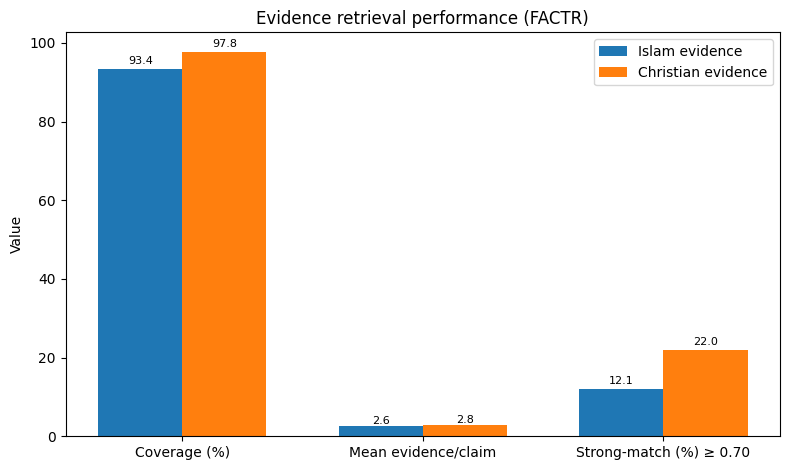

In [11]:
# Dissertation-ready figure: Evidence retrieval summary (bar chart)
metrics = ["Coverage (%)", "Mean evidence/claim", f"Strong-match (%) ≥ {STRONG_MATCH_THRESHOLD:.2f}"]
islam_vals = [
    100 * coverage_islam / n,
    mean_islam,
    100 * strong_islam / n
]
christian_vals = [
    100 * coverage_christian / n,
    mean_christian,
    100 * strong_christian / n
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4.8))
ax.bar(x - width/2, islam_vals, width, label="Islam evidence")
ax.bar(x + width/2, christian_vals, width, label="Christian evidence")

ax.set_ylabel("Value")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title("Evidence retrieval performance (FACTR)")
ax.legend()

# value labels
for i, v in enumerate(islam_vals):
    ax.text(i - width/2, v + (0.6 if v > 10 else 0.05), f"{v:.1f}", ha="center", va="bottom", fontsize=8)
for i, v in enumerate(christian_vals):
    ax.text(i + width/2, v + (0.6 if v > 10 else 0.05), f"{v:.1f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()

fig_path = EXPORT_DIR / "fig_evidence_retrieval_summary.png"
plt.savefig(fig_path, dpi=300)
fig_path

In [12]:
# Verdict distribution (overall)
vc = df_metrics["verdict_overall"].value_counts().sort_index()
vc

verdict_overall
agreement       40
conflicted      29
doubtful         7
insufficient    15
Name: count, dtype: int64

WindowsPath('c:/Users/lukmaan/reports/analysis_outputs/fig_verdict_distribution.png')

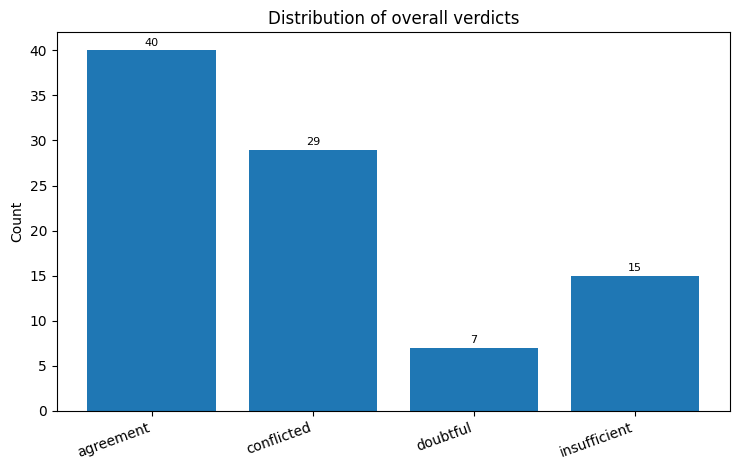

In [13]:
fig, ax = plt.subplots(figsize=(7.5, 4.8))
ax.bar(vc.index.astype(str), vc.values)
ax.set_ylabel("Count")
ax.set_title("Distribution of overall verdicts")
plt.xticks(rotation=20, ha="right")

for i, v in enumerate(vc.values):
    ax.text(i, v + 0.3, str(v), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
fig_path = EXPORT_DIR / "fig_verdict_distribution.png"
plt.savefig(fig_path, dpi=300)
fig_path

C:\Users\lukmaan\AppData\Local\Temp\ipykernel_45588\713556336.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels)


WindowsPath('c:/Users/lukmaan/reports/analysis_outputs/fig_confidence_by_verdict.png')

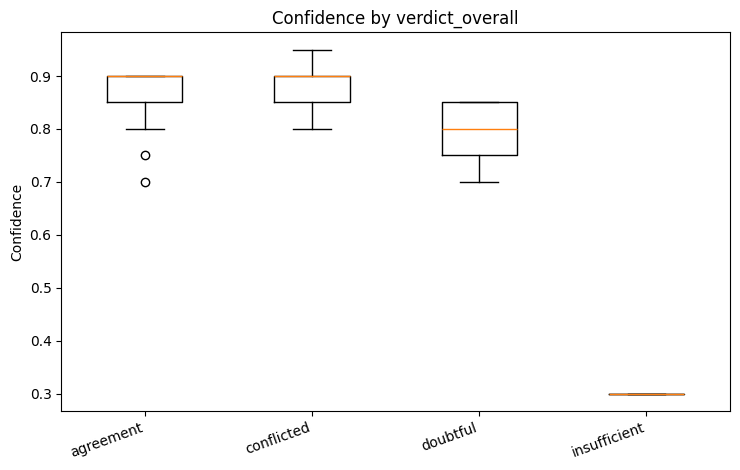

In [14]:
# Confidence by verdict category (boxplot)
groups = []
labels = []
for k, g in df_metrics.groupby("verdict_overall"):
    vals = pd.to_numeric(g["confidence"], errors="coerce").dropna().values
    if len(vals):
        groups.append(vals)
        labels.append(str(k))

fig, ax = plt.subplots(figsize=(7.5, 4.8))
ax.boxplot(groups, labels=labels)
ax.set_ylabel("Confidence")
ax.set_title("Confidence by verdict_overall")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()

fig_path = EXPORT_DIR / "fig_confidence_by_verdict.png"
plt.savefig(fig_path, dpi=300)
fig_path

## User feedback (`factr_verdict_feedback.jsonl`)

This section summarises the *qualitative* and *reaction* feedback captured during user testing.

In [3]:
from pathlib import Path
import json
import pandas as pd

# Hard-coded location (your known fixed path)
feedback_file = Path(r"C:\Users\lukmaan\Msc_in_AI\FATCR\factr_verdict_feedback.jsonl")

# Safety check
if not feedback_file.exists():
    raise FileNotFoundError(f"Feedback file not found at: {feedback_file}")

print("Feedback file:", feedback_file)

# Load JSONL into a DataFrame
rows = []
with feedback_file.open(encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            rows.append(json.loads(line))

fb = pd.DataFrame(rows)

# Convert timestamp column if present
if "timestamp" in fb.columns:
    fb["timestamp"] = pd.to_datetime(fb["timestamp"], errors="coerce")
    fb.sort_values("timestamp", inplace=True)

print("Feedback rows:", len(fb))
display(fb.head(5))


Feedback file: C:\Users\lukmaan\Msc_in_AI\FATCR\factr_verdict_feedback.jsonl
Feedback rows: 12


,timestamp,claim_id,claim_text,verdict_islam,verdict_christian,verdict_overall,confidence,reaction,comment,user_tag
0,2025-12-12 11:42:05,8ba76dad_000,"According to Jesus, the true God is three pers...",disagrees,agrees,conflicted,0.9,thumbs_up,None,lukmaan
1,2025-12-12 11:43:33,8ba76dad_001,Jesus is all three persons of the true God.,disagrees,agrees,conflicted,0.9,thumbs_up,None,lukmaan
2,2025-12-12 11:53:11,8ba76dad_000,"According to Jesus, the true God is three pers...",disagrees,agrees,conflicted,0.9,thumbs_up,None,lukmaan
3,2025-12-12 11:54:40,8ba76dad_000,"According to Jesus, the true God is three pers...",disagrees,agrees,conflicted,0.9,thumbs_down,does not make sense because the bible verses a...,lukmaan
4,2025-12-12 11:55:48,8ba76dad_001,Jesus is all three persons of the true God.,disagrees,agrees,conflicted,0.9,thumbs_down,ok but needs enhancing,lukmaan


In [5]:
# Reaction summary
reaction_counts = fb["reaction"].value_counts(dropna=False)
reaction_pct = (reaction_counts / len(fb) * 100).round(1)

summary_feedback = pd.DataFrame({
    "reaction": reaction_counts.index.astype(str),
    "count": reaction_counts.values,
    "percent": reaction_pct.values
})

summary_feedback

,reaction,count,percent
0,thumbs_up,6,50.0
1,thumbs_down,3,25.0
2,comment,3,25.0


WindowsPath('c:/Users/lukmaan/Msc_in_AI/FATCR/reports/analysis_outputs/fig_feedback_reactions.png')

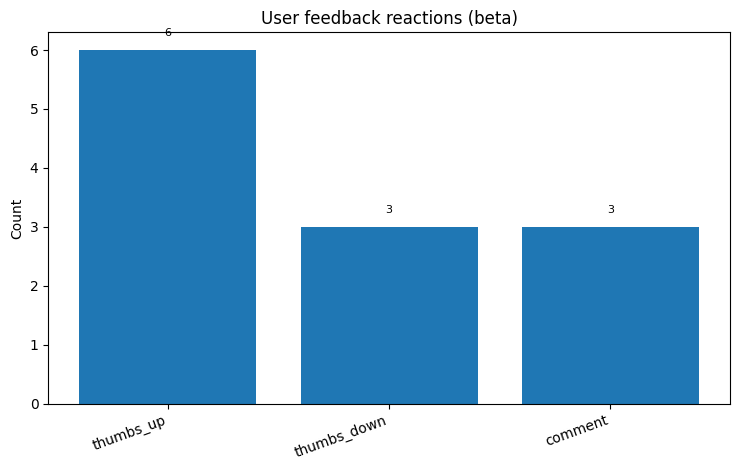

In [6]:
fig, ax = plt.subplots(figsize=(7.5, 4.8))
ax.bar(summary_feedback["reaction"], summary_feedback["count"])
ax.set_ylabel("Count")
ax.set_title("User feedback reactions (beta)")
plt.xticks(rotation=20, ha="right")

for i, v in enumerate(summary_feedback["count"].values):
    ax.text(i, v + 0.2, str(v), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
fig_path = EXPORT_DIR / "fig_feedback_reactions.png"
plt.savefig(fig_path, dpi=300)
fig_path

In [7]:
# Feedback per tester (user_tag)
if "user_tag" in fb.columns:
    per_user = fb["user_tag"].fillna("(unknown)").value_counts()
    per_user

In [8]:
# Extract and rank common terms from comments (lightweight, no extra deps)
comments = fb["comment"].dropna().astype(str)
comments = comments[comments.str.strip().ne("")]

stop = set('''
a an and are as at be because but by can do does for from had has have he her him his i in is it its 
just like make makes more my no not of on or our out she so that the their then there they this to 
up was we were what when where which who will with you your
'''.split())

def tokenize(text):
    words = re.findall(r"[a-zA-Z']{3,}", text.lower())
    return [w for w in words if w not in stop]

from collections import Counter
term_counts = Counter()
for c in comments:
    term_counts.update(tokenize(c))

top_terms = pd.DataFrame(term_counts.most_common(15), columns=["term","count"])
top_terms

,term,count
0,sense,2
1,bible,1
2,verses,1
3,wrong,1
4,needs,1
5,enhancing,1
6,thanks,1
7,sharia,1
8,would,1
9,dictate,1


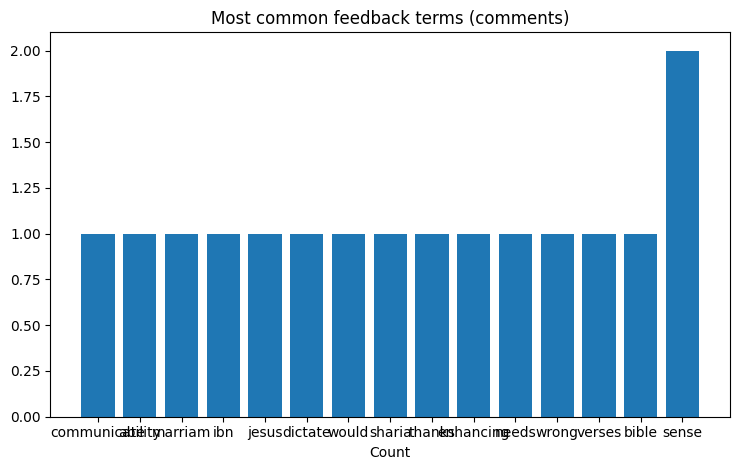

In [9]:
if len(top_terms):
    fig, ax = plt.subplots(figsize=(7.5, 4.8))
    ax.bar(top_terms["term"][::-1], top_terms["count"][::-1])
    ax.set_title("Most common feedback terms (comments)")
    ax.set_xlabel("Count")
    plt.tight_layout()
    fig_path = EXPORT_DIR / "fig_feedback_top_terms.png"
    plt.savefig(fig_path, dpi=300)
    fig_path

In [10]:
# Export feedback summaries (for dissertation appendix)
fb_csv = EXPORT_DIR / "feedback_raw.csv"
summary_csv = EXPORT_DIR / "feedback_reaction_summary.csv"

fb.to_csv(fb_csv, index=False)
summary_feedback.to_csv(summary_csv, index=False)

print("Saved:", fb_csv)
print("Saved:", summary_csv)

Saved: c:\Users\lukmaan\Msc_in_AI\FATCR\reports\analysis_outputs\feedback_raw.csv
Saved: c:\Users\lukmaan\Msc_in_AI\FATCR\reports\analysis_outputs\feedback_reaction_summary.csv


## Suggested dissertation write-up (copy/paste starter)

- **Quantitative (evidence retrieval):** report coverage, mean evidence count, and strong-match rate using `table_evidence_retrieval_summary.csv`.
- **Qualitative (user feedback):** report reaction distribution (`fig_feedback_reactions.png`) and include 2–5 short anonymised quotes that illustrate common themes.
- **Triangulation:** contrast *high confidence but negative feedback* cases to discuss limits of confidence calibration and the importance of explanation quality.

All exported assets are saved in: `reports/analysis_outputs/`